In [4]:
from pathlib import Path
import xarray as xr
import fsspec

download_path = Path("~/downloads").expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Update this to your new forecast day
day = "2022-09-14"

# Load dataset
url = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
ds = xr.open_zarr(fsspec.get_mapper(url), chunks=None)

# Download surface-level variables
if not (download_path / f"{day}-surface-level.nc").exists():
    surface_vars = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure",
    ]
    ds_surf = ds[surface_vars].sel(time=day).compute()
    ds_surf.to_netcdf(str(download_path / f"{day}-surface-level.nc"))
    print("Surface-level variables downloaded!")

# Download atmospheric variables
if not (download_path / f"{day}-atmospheric.nc").exists():
    atmos_vars = [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "specific_humidity",
        "geopotential",
    ]
    ds_atmos = ds[atmos_vars].sel(time=day).compute()
    ds_atmos.to_netcdf(str(download_path / f"{day}-atmospheric.nc"))
    print("Atmospheric variables downloaded!")


In [20]:
import numpy as np
import torch
import xarray as xr
from pathlib import Path
from aurora import Batch, Metadata

# ---------------- SETUP ----------------
download_path = Path("~/downloads").expanduser()
day = "2022-09-14"

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / f"{day}-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / f"{day}-atmospheric.nc", engine="netcdf4")

def _prepare(x: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(x[[1, 2]][None][..., ::-1, :].copy())  # pick 06:00 and 12:00

# ---------------- BASELINE BATCH ----------------
u_baseline = atmos_vars_ds["u_component_of_wind"].values.copy()
v_baseline = atmos_vars_ds["v_component_of_wind"].values.copy()

batch_original = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(u_baseline),
        "v": _prepare(v_baseline),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[2],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

# ---------------- PERTURBED BATCH ----------------
u = atmos_vars_ds["u_component_of_wind"].values.copy()
v = atmos_vars_ds["v_component_of_wind"].values.copy()

# Target: Nanmadol's center
lat_vals = atmos_vars_ds.latitude.values
lon_vals = atmos_vars_ds.longitude.values
lat_idx = np.argmin(np.abs(lat_vals - 22.9))
lon_idx = np.argmin(np.abs(lon_vals - 140.3))
level_idx = 5  # or check for 850 hPa

# Apply perturbation
for t_idx in [0, 1, 2, 3]:
    for level_idx in [8, 10, 12]:  # 850–500 hPa range
        u[t_idx, level_idx, lat_idx-5:lat_idx+6, lon_idx-5:lon_idx+6] += 50
#Perturb broader areas and longer durations

batch = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(u),
        "v": _prepare(v),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[2],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)


## track comparison

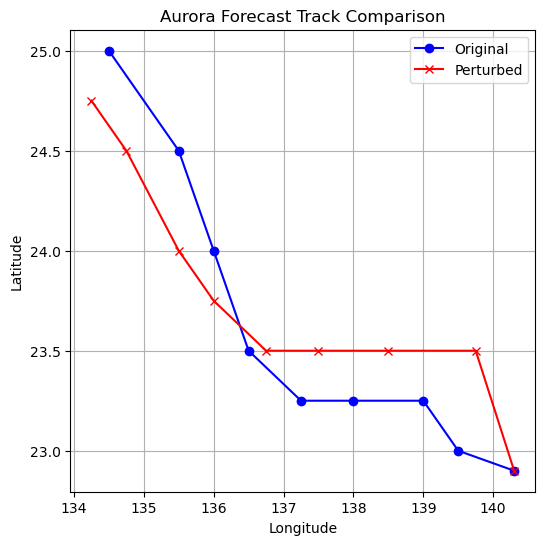

Step 1: track deviation = 0.00 km
Step 2: track deviation = 62.05 km
Step 3: track deviation = 62.05 km
Step 4: track deviation = 62.05 km
Step 5: track deviation = 62.05 km
Step 6: track deviation = 62.05 km
Step 7: track deviation = 55.50 km
Step 8: track deviation = 83.25 km
Step 9: track deviation = 39.24 km


In [21]:
from datetime import datetime

from aurora import Aurora, Tracker, rollout

model = Aurora()
model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")

# Initialise the tracker with the position of Nanmadol at 14 Sept 2022 at UTC 12. Taken from
# IBTrACS: https://ncics.org/ibtracs/index.php?name=v04r01-2022254N24143
tracker = Tracker(init_lat=22.9, init_lon=140.3, init_time=datetime(2022, 9, 14, 12, 0))

model.eval()
model = model.to("cuda")

# ---------- TRACKING FUNCTION ----------
def run_and_compare_tracks(model, batch_original, batch_perturbed, steps=8):
    tracker_orig = Tracker(init_lat=22.9, init_lon=140.3, init_time=datetime(2022, 9, 14, 12))
    tracker_pert = Tracker(init_lat=22.9, init_lon=140.3, init_time=datetime(2022, 9, 14, 12))
    preds_orig, preds_pert = [], []

    with torch.inference_mode():
        for pred_o, pred_p in zip(
            rollout(model, batch_original, steps=steps),
            rollout(model, batch_perturbed, steps=steps)
        ):
            preds_orig.append(pred_o.to("cpu"))
            preds_pert.append(pred_p.to("cpu"))
            tracker_orig.step(pred_o)
            tracker_pert.step(pred_p)

    # Extract results
    orig = tracker_orig.results()
    pert = tracker_pert.results()

    # Plot tracks
    plt.figure(figsize=(6, 6))
    plt.plot(orig.lon, orig.lat, marker='o', label='Original', color='blue')
    plt.plot(pert.lon, pert.lat, marker='x', label='Perturbed', color='red')
    plt.title("Aurora Forecast Track Comparison")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print deviation at each step
    dist_km = np.sqrt(((np.array(pert.lat) - np.array(orig.lat))**2 + (np.array(pert.lon) - np.array(orig.lon))**2)) * 111
    for i, d in enumerate(dist_km):
        print(f"Step {i+1}: track deviation = {d:.2f} km")

    return preds_orig, preds_pert, orig, pert

# ---------- RUN COMPARISON ----------
# batch_original: from earlier (unperturbed)
# batch: the perturbed one you're testing
preds_orig, preds_pert, track_orig, track_pert = run_and_compare_tracks(model, batch_original, batch)

model = model.to("cpu")  # free GPU

## Plot tracks

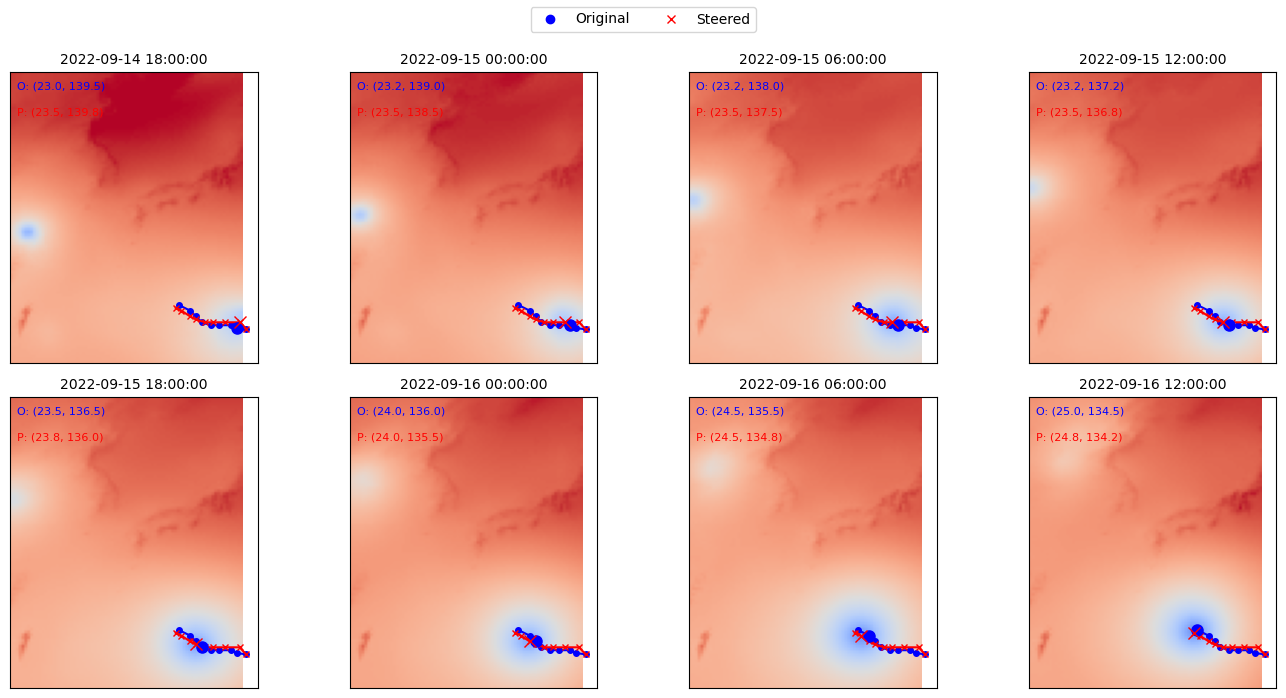

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(14, 7))  # slightly wider for both tracks

for i in range(8):
    pred = preds_pert[i]  # show MSL from perturbed batch
    ax = axs[i // 4, i % 4]

    # Mask lat-lon area around Nanmadol
    lat_mask = (pred.metadata.lat >= 20) & (pred.metadata.lat <= 45)
    lon_mask = (pred.metadata.lon >= 120) & (pred.metadata.lon <= 140)

    # Plot perturbed forecast surface pressure
    ax.imshow(
        pred.surf_vars["msl"][0, 0][lat_mask][:, lon_mask].numpy() / 100,
        vmin=970,
        vmax=1020,
        extent=(120, 140, 20, 45),
        cmap="coolwarm",
    )

    # Titles and ticks
    ax.set_title(str(pred.metadata.time[0]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot original and perturbed tracks
    ax.plot(track_orig.lon, track_orig.lat, c="blue", marker="o", markersize=4, label="Original")
    ax.plot(track_pert.lon, track_pert.lat, c="red", marker="x", markersize=4, label="Steered")

    # Highlight current step for both tracks
    time_i = pred.metadata.time[0]

    this_step_orig = track_orig[track_orig.time == time_i]
    this_step_pert = track_pert[track_pert.time == time_i]

    if not this_step_orig.empty:
        ax.plot(this_step_orig.lon, this_step_orig.lat, c="blue", marker="o", markersize=8)
        ax.text(
            0.03,
            0.94,
            f"O: ({this_step_orig.lat.iloc[0]:.1f}, {this_step_orig.lon.iloc[0]:.1f})",
            transform=ax.transAxes,
            fontsize=8,
            color="blue",
        )
    if not this_step_pert.empty:
        ax.plot(this_step_pert.lon, this_step_pert.lat, c="red", marker="x", markersize=8)
        ax.text(
            0.03,
            0.85,
            f"P: ({this_step_pert.lat.iloc[0]:.1f}, {this_step_pert.lon.iloc[0]:.1f})",
            transform=ax.transAxes,
            fontsize=8,
            color="red",
        )

# Add shared legend
handles = [
    plt.Line2D([], [], color="blue", marker="o", linestyle="none", label="Original"),
    plt.Line2D([], [], color="red", marker="x", linestyle="none", label="Steered"),
]
fig.legend(handles=handles, loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()
